<a href="https://colab.research.google.com/github/jack-kennedy56/jack-kennedy56/blob/main/SCAProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [299]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns

In [301]:
# create a list of dictionaries to hold the data
data = []

# generate random data and append it to the list
for i in range(450):
  date = datetime.datetime(2020, random.randint(1, 12), random.randint(1, 28))
  time = datetime.time(random.randint(0, 23), random.randint(0, 59), random.randint(0, 59))
  weather_status = random.randint(0, 1)
  urban_location = random.randint(0, 1)
  distance_miles = round(random.uniform(0, 100), 3)
  product_type = random.choice(['Food', 'Clothing', 'Household', 'Other'])
  late = random.randint(0, 1)
  
  data.append({
      'Order_date': date,
      'Time_ordered': time,
      'Weather_status': weather_status,
      'Urban_location': urban_location,
      'Distance_miles': distance_miles,
      'Product_type': product_type,
      'Late': late
  })

# create the data frame from the list of dictionaries
df = pd.DataFrame(data, columns=['Order_date', 'Time_ordered', 'Weather_status', 'Urban_location', 'Distance_miles', 'Product_type', 'Late'])

# print the data frame
print(df)

    Order_date Time_ordered  Weather_status  Urban_location  Distance_miles  \
0   2020-12-26     04:14:49               0               0          35.812   
1   2020-07-19     02:43:15               0               0          91.183   
2   2020-11-20     22:59:21               1               1          84.446   
3   2020-07-06     23:27:59               0               1          34.512   
4   2020-10-27     03:25:55               1               1          81.699   
..         ...          ...             ...             ...             ...   
445 2020-02-11     04:00:50               1               1          92.546   
446 2020-05-22     12:24:30               1               0          58.258   
447 2020-09-19     05:43:49               1               1          34.917   
448 2020-03-02     18:32:18               1               0          29.882   
449 2020-07-27     23:29:44               0               0          72.389   

    Product_type  Late  
0           Food     0  
1

In [303]:
df.head()

,Order_date,Time_ordered,Weather_status,Urban_location,Distance_miles,Product_type,Late
0,2020-12-26,04:14:49,0,0,35.812,Food,0
1,2020-07-19,02:43:15,0,0,91.183,Household,0
2,2020-11-20,22:59:21,1,1,84.446,Clothing,0
3,2020-07-06,23:27:59,0,1,34.512,Household,0
4,2020-10-27,03:25:55,1,1,81.699,Household,0


In [302]:
#print what percentage of imbalance in fraud
print('On Time', round(df['Late'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Late', round(df['Late'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

On Time 51.56 % of the dataset
Late 48.44 % of the dataset


In [304]:
df['Product_type'] = df["Product_type"].replace('Food','1')
df['Product_type'] = df["Product_type"].replace('Clothing','2')
df['Product_type'] = df["Product_type"].replace('Household','3')
df['Product_type'] = df["Product_type"].replace('Other','4')

In [305]:
# convert the Order_date column to a numerical value
df['Order_date_numeric'] = df['Order_date'].apply(lambda x: datetime.datetime.timestamp(x))

# drop the Order_date column
df = df.drop(columns=['Order_date'])

In [306]:
df.head()

,Time_ordered,Weather_status,Urban_location,Distance_miles,Product_type,Late,Order_date_numeric
0,04:14:49,0,0,35.812,1,0,1.608941e+09
1,02:43:15,0,0,91.183,3,0,1.595117e+09
2,22:59:21,1,1,84.446,2,0,1.605830e+09
3,23:27:59,0,1,34.512,3,0,1.593994e+09
4,03:25:55,1,1,81.699,3,0,1.603757e+09


In [307]:
df = df.drop(['Time_ordered'], axis = 1)

In [308]:
df_late = df['Late']
df = df.drop(['Late'], axis = 1)

In [309]:
scaler = StandardScaler()
df_norm = scaler.fit_transform(df)

In [310]:
df_norm = pd.DataFrame(df_norm, columns=df.columns)

In [311]:
df_norm = pd.concat([df_norm, df_late], axis=1)

In [312]:
df_norm.head()

,Weather_status,Urban_location,Distance_miles,Product_type,Order_date_numeric,Late
0,-0.986754,-0.952250,-0.508123,-1.352270,1.740470,0
1,-0.986754,-0.952250,1.374031,0.483391,0.224491,0
2,1.013423,1.050145,1.145029,-0.434440,1.399375,0
3,-0.986754,1.050145,-0.552312,0.483391,0.101318,0
4,1.013423,1.050145,1.051654,0.483391,1.171978,0


In [313]:
input_data = df_norm[['Order_date_numeric', 'Weather_status', 'Urban_location', 'Distance_miles', 'Product_type']]
target = df_norm['Late']

In [314]:
#split data in train and test
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, Y_train, Y_test = train_test_split(input_data, target, 
                                                    train_size = 0.80, test_size = 0.20, random_state = 1)

In [315]:
#setup beofre creating knn classifier 
neighbours = np.arange(1,50)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,Y_train.values.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train.values.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test.values.ravel()) 

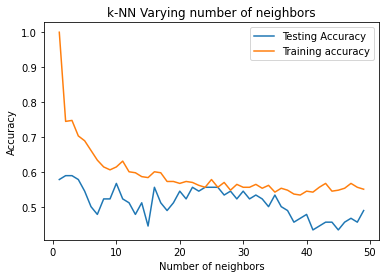

In [316]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [317]:
#identify best value for n_neighbours
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [318]:
#print best value for n_neighbours
print(x[0])

2


In [319]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,Y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2)

In [320]:
#predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

In [321]:
#scoring KNN
knn_accuracy_score  = accuracy_score(Y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(Y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(Y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(Y_test,knn_predicted_test_labels)
knn_MCC             = matthews_corrcoef(Y_test,knn_predicted_test_labels)

In [322]:
#print KNN score
print("")
print("K-Nearest Neighbours")
print("Scores")
print("Accuracy -->",knn_accuracy_score)
print("Precison -->",knn_precison_score)
print("Recall -->",knn_recall_score)
print("F1 -->",knn_f1_score)
print("MCC -->",knn_MCC)
print(classification_report(Y_test,knn_predicted_test_labels))


K-Nearest Neighbours
Scores
Accuracy --> 0.5888888888888889
Precison --> 0.8666666666666667
Recall --> 0.2708333333333333
F1 --> 0.41269841269841273
MCC --> 0.2988071523335984
              precision    recall  f1-score   support

           0       0.53      0.95      0.68        42
           1       0.87      0.27      0.41        48

    accuracy                           0.59        90
   macro avg       0.70      0.61      0.55        90
weighted avg       0.71      0.59      0.54        90



XGBoost

In [323]:
def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    return matrix, pred

In [324]:
def PrintStats(cmat, y_test, pred):
    tpos = cmat[0][0]
    fneg = cmat[1][1]
    fpos = cmat[0][1]
    tneg = cmat[1][0]

In [325]:
df.head()

,Weather_status,Urban_location,Distance_miles,Product_type,Order_date_numeric
0,0,0,35.812,1,1.608941e+09
1,0,0,91.183,3,1.595117e+09
2,1,1,84.446,2,1.605830e+09
3,0,1,34.512,3,1.593994e+09
4,1,1,81.699,3,1.603757e+09


In [326]:
xgb = xgb.XGBClassifier() 
cmat, pred = RunModel(xgb, X_train, Y_train, X_test, Y_test)
PrintStats(cmat, Y_test, pred)

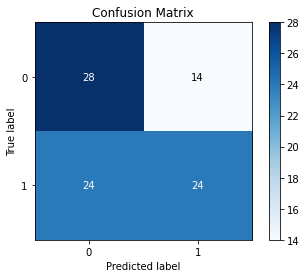

In [327]:
#print confusion matrix for XGBoost
skplt.metrics.plot_confusion_matrix(Y_test, pred)

In [328]:
#print classification report for XGBoost
print (classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.54      0.67      0.60        42
           1       0.63      0.50      0.56        48

    accuracy                           0.58        90
   macro avg       0.59      0.58      0.58        90
weighted avg       0.59      0.58      0.58        90



In [329]:
params={
 "learning_rate"    : [0.05, 0.1, 0.2, 0.3, 1 ] ,
 "max_depth"        : [10, 12, 15],
 "min_child_weight" : [ 1, 3 ],
 "gamma"            : [ 0.0, 0.15, 0.3]
    
}

In [330]:
random_search= RandomizedSearchCV(estimator = xgb,param_distributions=params,n_iter=10,scoring='f1',n_jobs=-1,cv=5)

In [331]:
random_search.fit(X_train,Y_train.ravel())

RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.15, 0.3],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          1],
                                        'max_depth': [10, 12, 15],
                                        'min_child_weight': [1, 3]},
                   scoring='f1')

In [336]:
xgb_tuned = xgb.XGBClassifier(gamma=0.3, learning_rate=1, max_depth=15) 
cmat, pred_tuned = RunModel(xgb_tuned, X_train, Y_train, X_test, Y_test)
PrintStats(cmat, Y_test, pred_tuned)

AttributeError: ignored

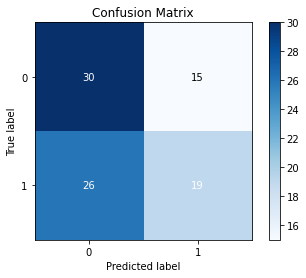

In [ ]:
#print confusion matrix for XGBoost tuned
skplt.metrics.plot_confusion_matrix(Y_test, pred)

In [ ]:
#print classification report for XGBoost tuned
print (classification_report(Y_test, pred_tuned))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55        45
           1       0.50      0.40      0.44        45

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.50      0.50      0.49        90



Randon Forest

In [ ]:
#create random forrest classifier
rf = RandomForestClassifier()

In [ ]:
#create parameters for testing
rf_params = {'n_estimators': [100,200,500],
            'max_features': [3,5,7],
            'min_samples_split':[5,10,20]}

In [ ]:
#use grid search cv to find best parameters
rf_cv_model = GridSearchCV(rf, rf_params, cv=7, n_jobs=-1, verbose=1).fit(X_train, Y_train)

Fitting 7 folds for each of 27 candidates, totalling 189 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
63 fits failed out of a total of 189.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", 

In [ ]:
#find best parameters for best model
best_params = rf_cv_model.best_params_
print(best_params)

{'max_features': 3, 'min_samples_split': 20, 'n_estimators': 100}


In [ ]:
rf = RandomForestClassifier(max_features=best_params['max_features'], min_samples_split=best_params['min_samples_split'], n_estimators=best_params['n_estimators']).fit(X_train, Y_train)

In [ ]:
#create the predicitons from the model
y_pred_rf = rf.predict(X_test)

In [ ]:
#get the accuracy score for the model
accuracy_score(Y_test, y_pred_rf)

0.4888888888888889

In [ ]:
#get cross validation score for the model
cross_val_score(rf, X_test, Y_test, cv=21).mean()

0.5809523809523809

In [ ]:
#get a classification report for the model
print(classification_report(Y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49        46
           1       0.48      0.50      0.49        44

    accuracy                           0.49        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.49      0.49      0.49        90



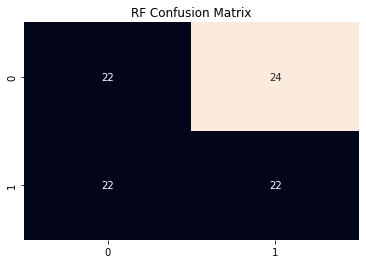

In [ ]:
#plot a confusion matrix for the model
cm = confusion_matrix(Y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('RF Confusion Matrix')
plt.savefig('rf_con_mat')
plt.show()